In [1]:
import os
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

from SpatioCAD import SpatioCAD

# Load data

The data can be download from <https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast>

In [2]:
h5ad_file_path = os.path.join("Data", "10x_Genomics", "CytAssist_FFPE_Human_Breast_Cancer", "raw_data.h5ad")
scad = SpatioCAD()
scad.read_h5ad(file=h5ad_file_path)
scad.preprocess(min_cells= 100, min_genes = 1, gene_normalize = True, log1p = True)
scad.adata

AnnData object with n_obs × n_vars = 4992 × 17633
    obs: 'in_tissue', 'array_row', 'array_col', 'Cluster', 'Annotation', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

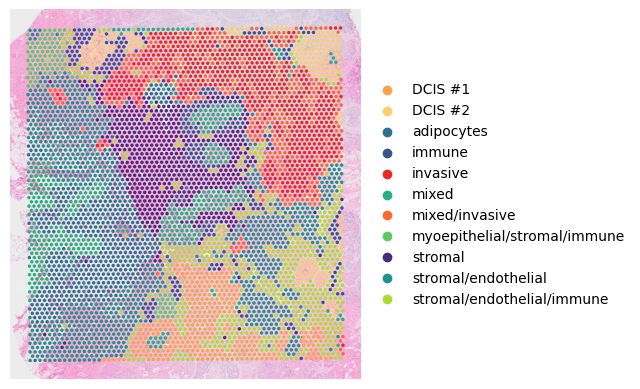

In [3]:
annotation_color_map_distinct = {
    'invasive': '#ea2920', 
    'mixed/invasive': '#fc6832', 
    'DCIS #1': '#fea245', 
    'DCIS #2': '#fece6a', 
    'stromal': '#472d7b', 
    'immune': '#3b528b', 
    'adipocytes': '#2c728e', 
    'stromal/endothelial': '#21918c', 
    'mixed': '#28ae80', 
    'myoepithelial/stromal/immune': '#5ec962', 
    'stromal/endothelial/immune': '#addc30'
}

sc.pl.spatial(
    scad.adata, color='Annotation', palette=annotation_color_map_distinct,
    title='',  show=True, frameon=False
)

# Filter the noise genes

We calculate a Roughness Score for each gene to quantify the signal changes during the initial phase of diffusion. 
Then we fit the the distribution of the Roughness Scores across all genes using a Gaussian Mixture Model (GMM).
The optimal number of GMM components is determined by BIC with the candidate numbers is determined by ``n_components_range''.

In [4]:
scad.compute_adjacency_matrix()
scad.filter_non_pattern_genes(n_components_range= range(1, 10))
scad.adata

AnnData object with n_obs × n_vars = 4992 × 17633
    obs: 'in_tissue', 'array_row', 'array_col', 'Cluster', 'Annotation', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'roughness_scores', 'gmm_component_label', 'is_noise_gene'
    uns: 'spatial', 'log1p', 'Annotation_colors', 'gmm_filter_results'
    obsm: 'spatial'
    layers: 'counts'

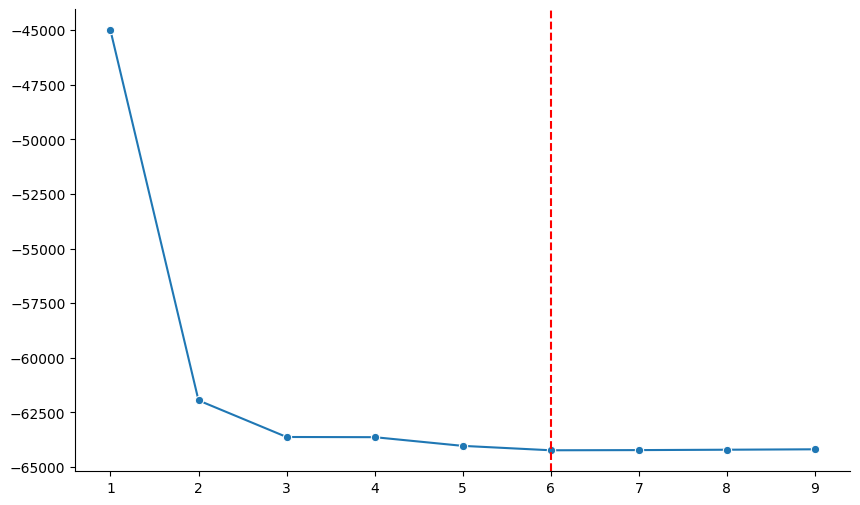

In [5]:
results = scad.adata.uns['gmm_filter_results']
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['tested_n_components'], y=results['bic_scores'], marker='o')
plt.axvline(x=results['optimal_n'], color='red', linestyle='--')
sns.despine()
plt.show()

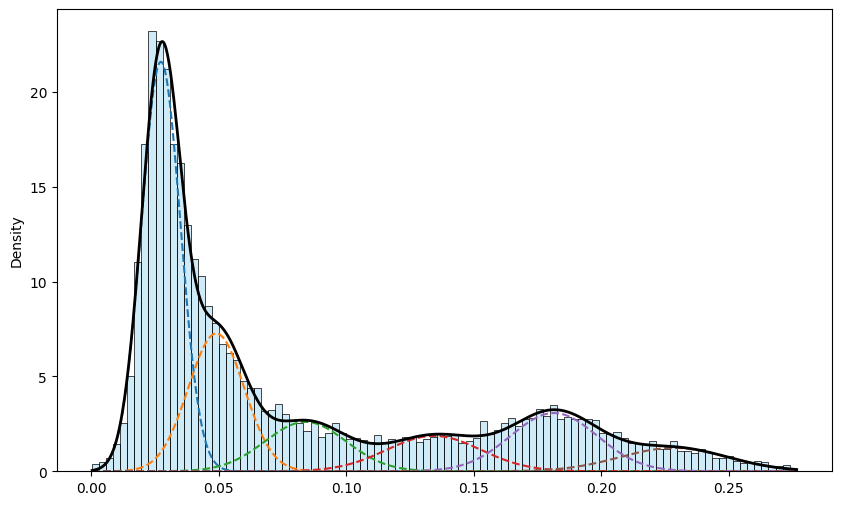

In [6]:
scores = scad.adata.var['roughness_scores'].values
x_range = np.linspace(scores.min(), scores.max(), 1000).reshape(-1, 1)

plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=100, stat='density', color='skyblue', alpha=0.4)

means, covs, weights = results['final_gmm_means'], results['final_gmm_covariances'], results['final_gmm_weights']
total_pdf = np.zeros_like(x_range.flatten())

for i in range(results['optimal_n']):
    pdf = norm.pdf(x_range, means[i], np.sqrt(covs[i])) * weights[i]
    total_pdf += pdf.flatten()
    color = 'red' if i in results['noise_component_indices'] else 'viridis'
    plt.plot(x_range, pdf, linestyle='--') 

plt.plot(x_range, total_pdf, color='black', linewidth=2)
plt.show()

# Identify spatially variable genes (SVGs)

We calculate a characteristic diffusion time for each gene, which quantifies how far is its expression pattern from the stable state under Node-Attributed Graph Diffusion framework.

In [7]:
svg_df = scad.compute_SVG()
svg_df

gene  robust_rank  is_noise_gene      1_power    1.5_power  \
0        SCGB2A2            1          False  2439.525655  2573.696954   
1          MUC16            2          False  2420.178973  2534.496754   
2           ERN2            3          False  2437.359519  2503.160788   
3          GRB14            4          False  2370.917767  2462.261008   
4         PCDH10            5          False  2358.185417  2461.908483   
...          ...          ...            ...          ...          ...   
17628  DOCK8-AS1        17067           True          NaN          NaN   
17629       TBR1        17067           True          NaN          NaN   
17630      DMRT1        17067           True          NaN          NaN   
17631      TEX33        17067           True          NaN          NaN   
17632   C12orf71        17067           True          NaN          NaN   

           2_power lex_sort_key  
0      2659.108499    (1, 1, 1)  
1      2634.463276    (2, 2, 3)  
2      2565.628335    (2, 3, 3)  
3      2550.110818    (4, 4, 5)  
4      2557.680928    (4, 5, 5)  
...            ...          ...  
17628          NaN          NaN  
17629          NaN          NaN  
17630          NaN          NaN  
17631          NaN          NaN  
17632          NaN          NaN  

[17633 rows x 7 columns]

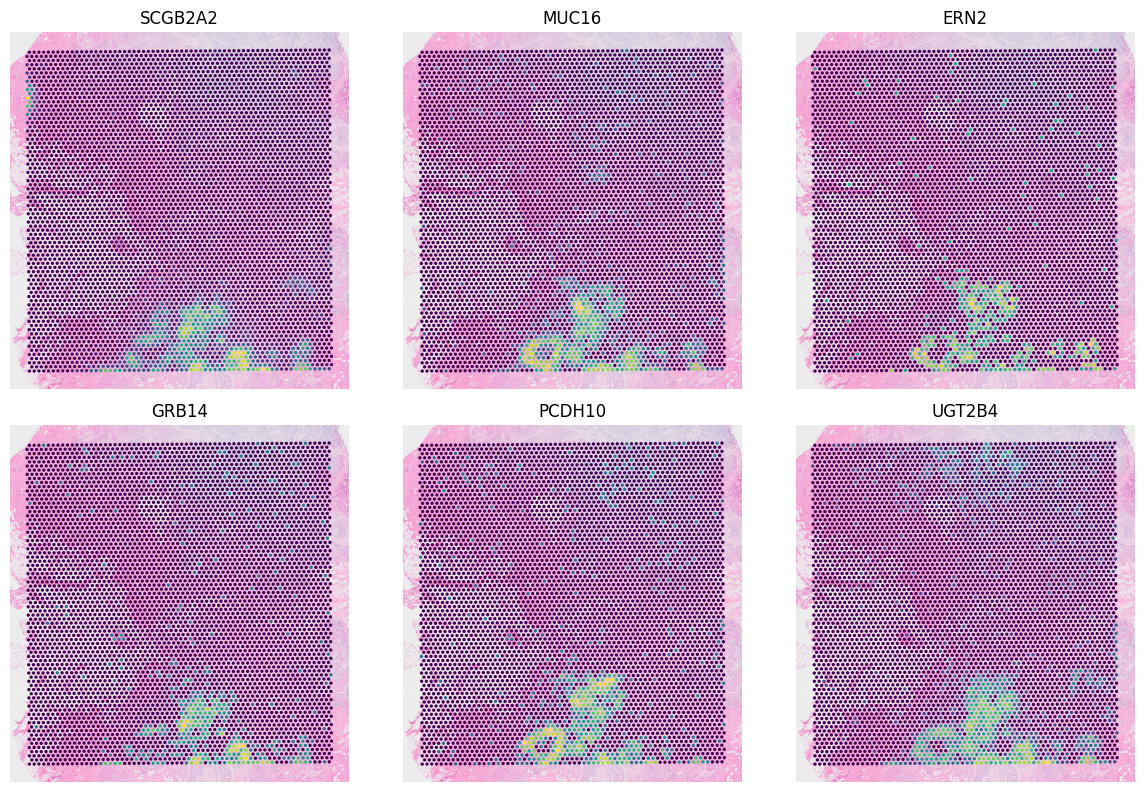

In [8]:
svg_list = svg_df['gene'].head(6).tolist()

ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = axes.flatten()

for i, gene in enumerate(svg_list):
    ax = axes[i]
    sc.pl.spatial(scad.adata, color=gene,cmap='viridis', title=gene, ax=ax, colorbar_loc=None,show=False,frameon=False)
    ax.set_xlabel("") 
    ax.set_ylabel("")

plt.tight_layout(pad=1.0)
plt.show() 

# Cluster top SVGs and visualize the gene pattern for each Cluster

In [9]:
scad.cluster_gene(n_top_genes = 2000)
scad.compute_cluster_patterns(vote_rate = 0.25)

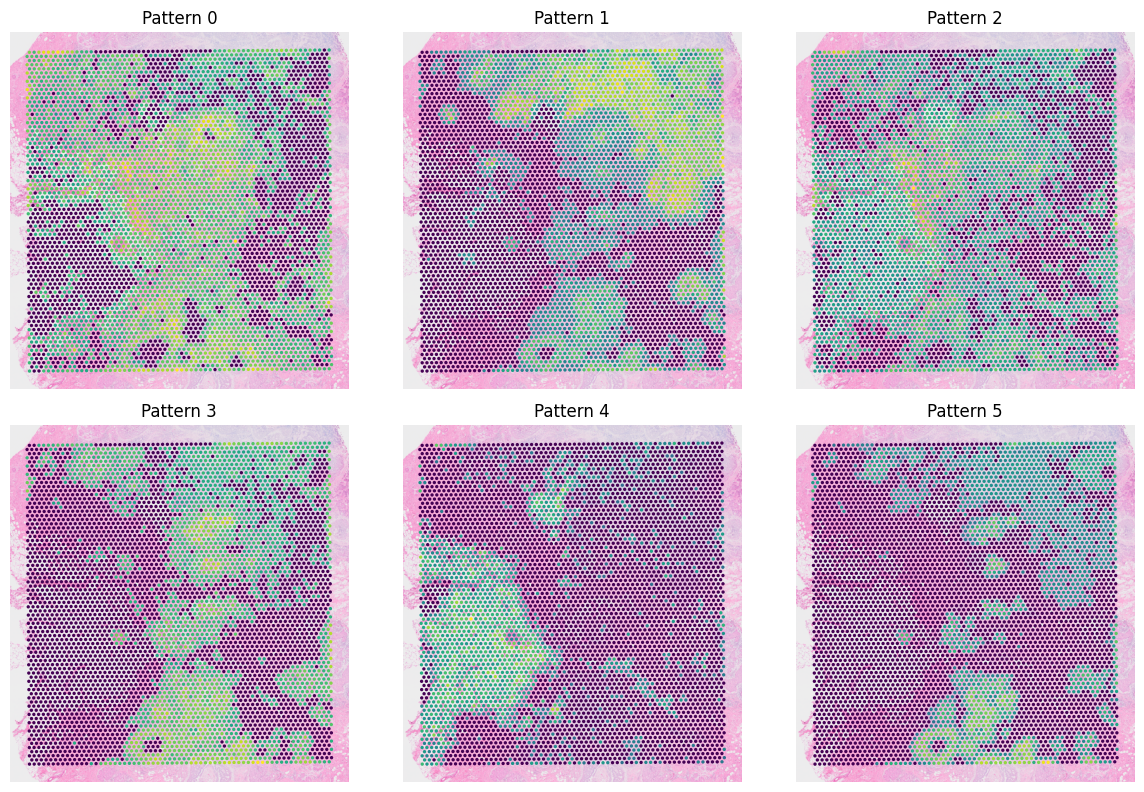

In [10]:
cluster_labels = range(6)

ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    sc.pl.spatial(scad.adata, color=f'cluster_{i}_pattern',cmap='viridis', title=f'Pattern {i}', ax=ax, colorbar_loc=None,show=False,frameon=False)
    ax.set_xlabel("") 
    ax.set_ylabel("")

plt.tight_layout(pad=1.0)
plt.show() 